In [1]:
from sklearn.model_selection import  KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import Ridge
import pandas as pd
import seaborn as sns

## QUESTION 2.1

In [2]:
df = pd.read_csv("../Desktop/prostate.data.txt", delimiter="\t").drop(["Unnamed: 0", "train"], axis=1)

In [3]:
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


In [4]:
# Standardizing the values of the data to remove the different scales
df_standardize = (df - df.mean(axis=0))/df.std(axis=0) 

In [5]:
df_standardize.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-1.637356,-2.006212,-1.862426,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.520226
1,-1.988980,-0.722009,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.287827
2,-1.578819,-2.188784,1.361163,-1.024706,-0.522941,-0.863171,0.342627,-0.155348,-2.287827
3,-2.166917,-0.807994,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.287827
4,-0.507874,-0.458834,-0.250631,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-1.825150


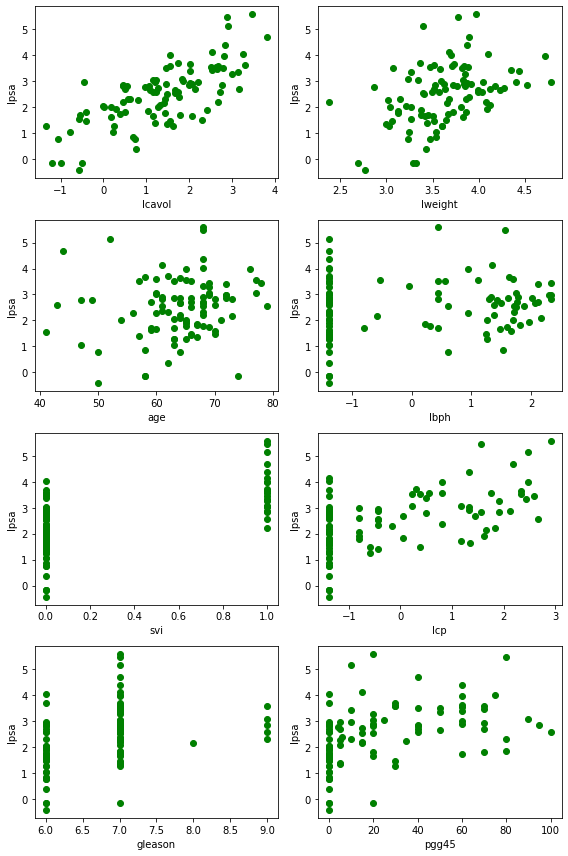

In [6]:
fig, ax = plt.subplots(4,2, figsize=(8, 12))
for a, b, df_x, df_y in zip(np.repeat(range(len(ax)), 2), list(range(2)) * len(ax), 
                   df_standardize.columns.drop("lpsa"), list(df.columns)[-1:] * len(df_standardize.columns.drop("lpsa"))):
    ax[a][b].scatter(df[df_x], df[df_y], color="green")
    ax[a][b].set_xlabel(df_x)
    ax[a][b].set_ylabel(df_y)
    plt.tight_layout()

## QUESTION 2.2

In [7]:
X = df.drop("lpsa", axis=1)
y = df["lpsa"]

In [8]:
X_val = np.c_[np.ones((len(X), 1)), X]
w = np.linalg.inv(X_val.T.dot(X_val)).dot(X_val.T).dot(y.values)

In [9]:
# taking samples from the posterior of w in Question 1 over this data set
w

array([ 0.18156085,  0.56434128,  0.62201979, -0.02124819,  0.09671252,
        0.7616734 , -0.10605094,  0.04922793,  0.00445751])

In [10]:
def calc_posterior_analytical(data, x, μ_0, σ_0):
    σ = 1.
    n = len(data)
    μ_post = (μ_0 / σ_0**2 + data.sum() / σ**2) / (1. / σ_0**2 + n / σ**2)
    σ_post = (1. / σ_0**2 + n / σ**2)**-1
    return norm(μ_post, np.sqrt(σ_post)).pdf(x)

In [11]:
def sampler(data, samples=4, μ_init=.5, suggested_width=.5, plot=False, μ_prior_μ=0, μ_prior_sd=1.):
    current_μ = μ_init
    posterior = [current_μ]
    for i in range(samples):
        # Propose new position of μ
        proposed_μ = norm(current_μ, suggested_width).rvs()

        # Multiplying the probabilities of each data point to compute likelihood
        Current_likelihood = norm(current_μ, 1).pdf(data).prod()
        Proposed_likelihood = norm(proposed_μ, 1).pdf(data).prod()
        
        # Prior Probability of current and proposed μ Computation        
        Current_prior = norm(μ_prior_μ, μ_prior_sd).pdf(current_μ)
        Proposed_prior = norm(μ_prior_μ, μ_prior_sd).pdf(proposed_μ)
        
        p_current = Current_likelihood * Current_prior
        p_proposal = Proposed_likelihood * Proposed_prior
        
        # To accept proposal
        p_accept = p_proposal / p_current
        
        # For simplicity prior probability was not included
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(current_μ, proposed_μ, μ_prior_μ, μ_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update μ
            current_μ = proposed_μ
        
        posterior.append(current_μ)
        
    return np.array(posterior)

C:\Users\emman\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\emman\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\emman\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

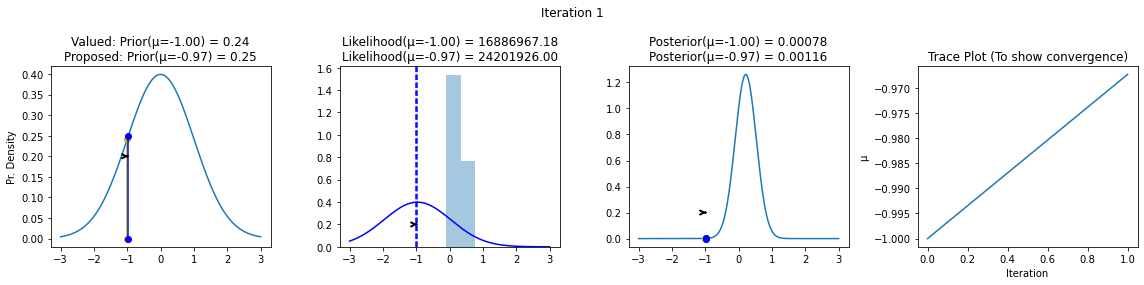

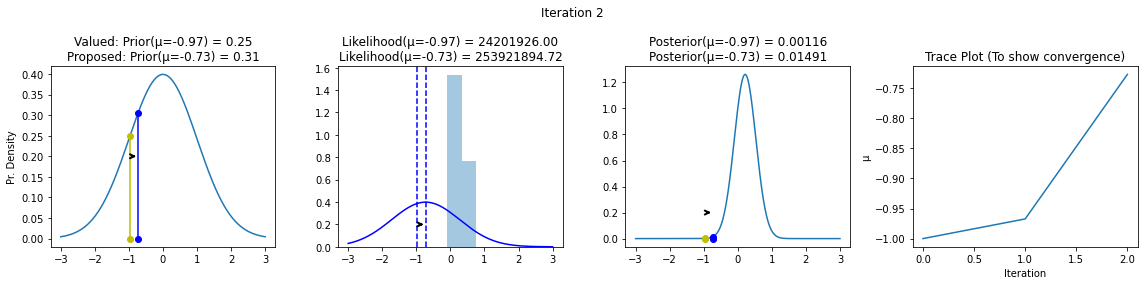

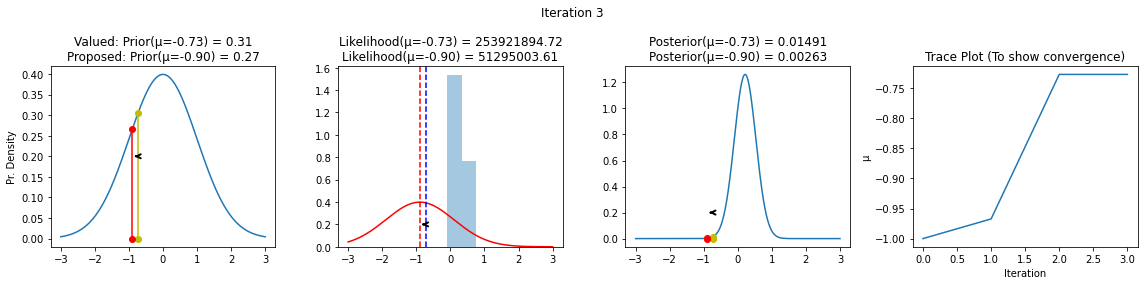

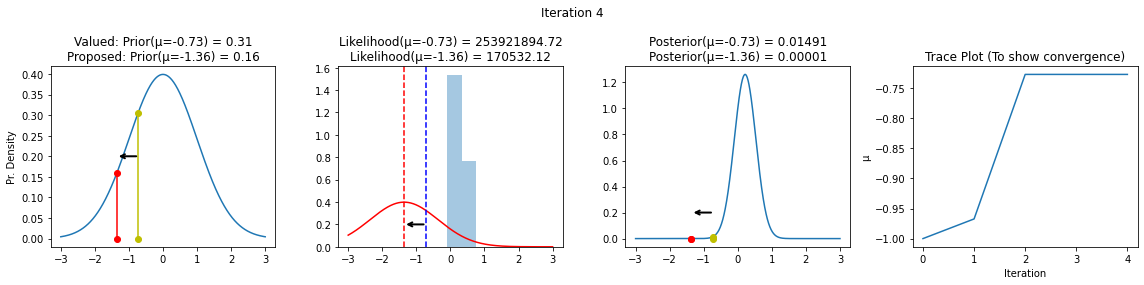

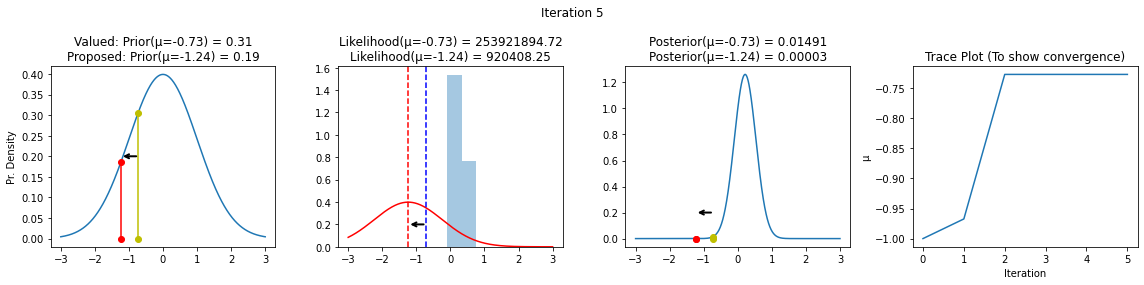

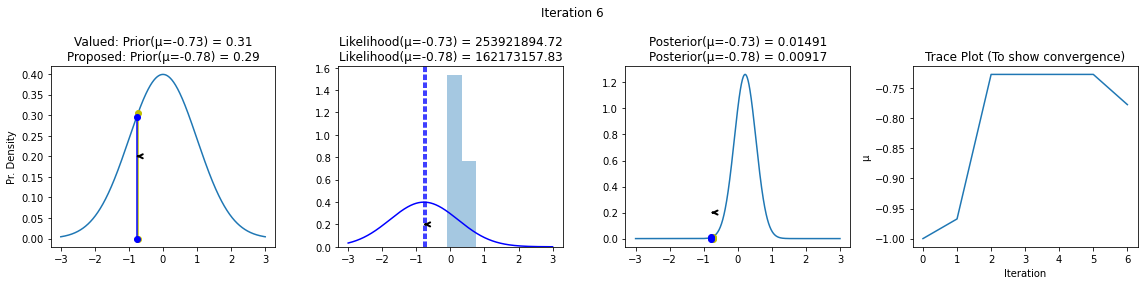

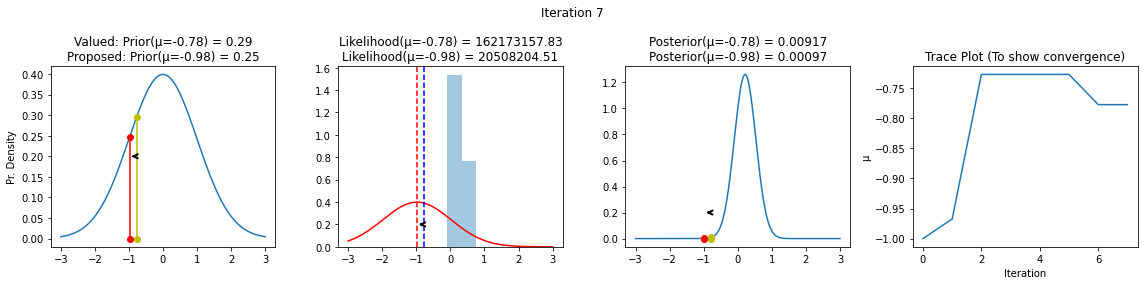

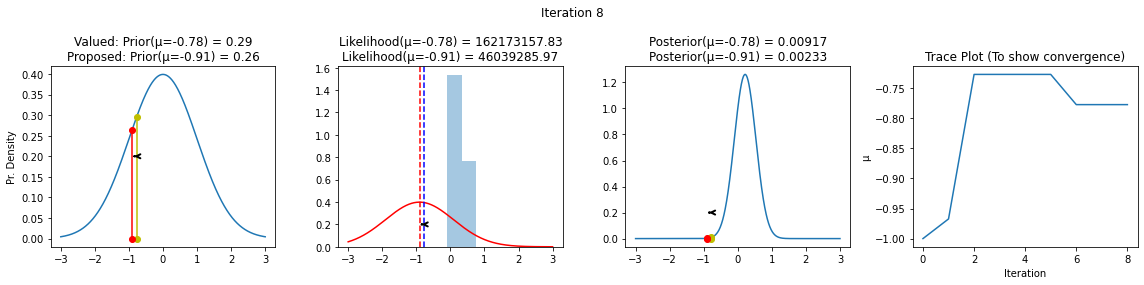

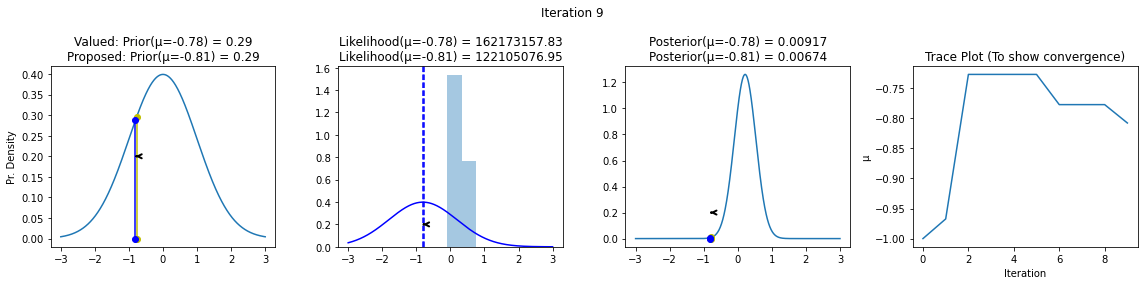

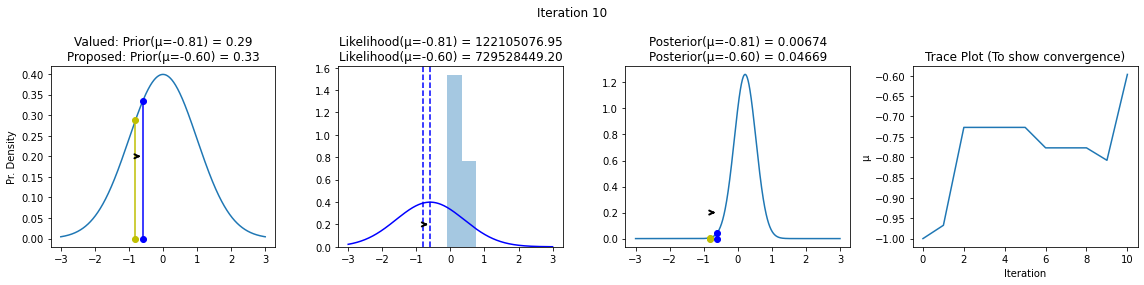

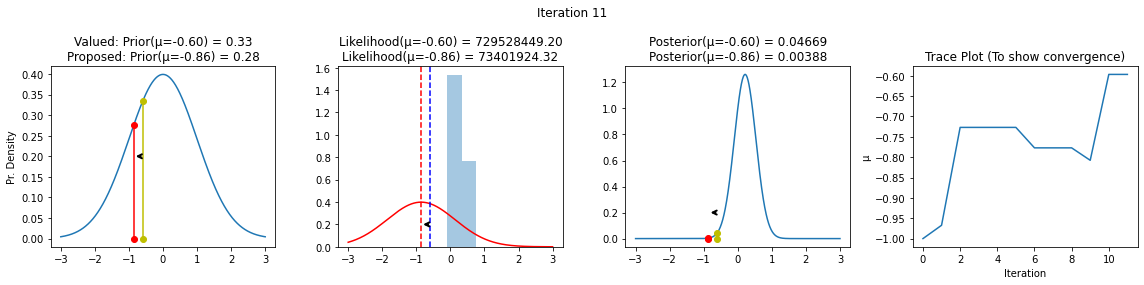

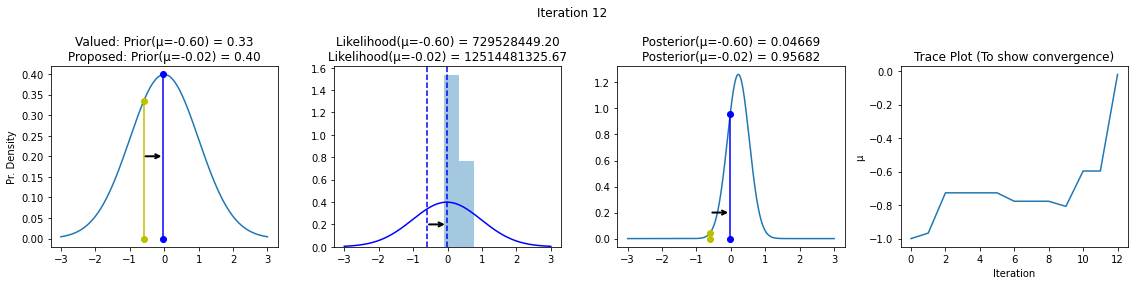

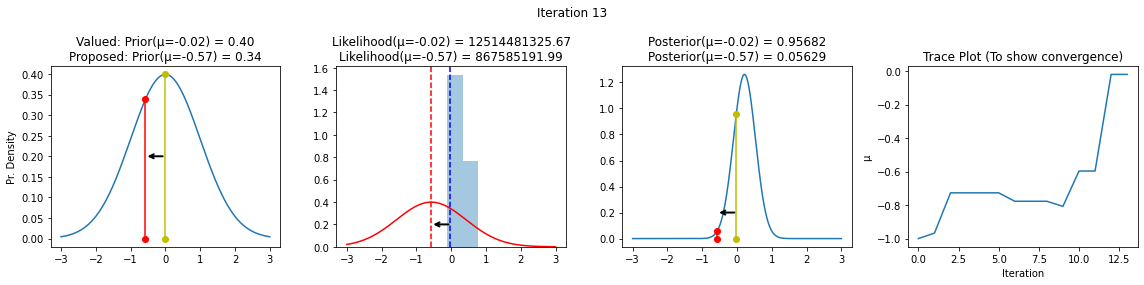

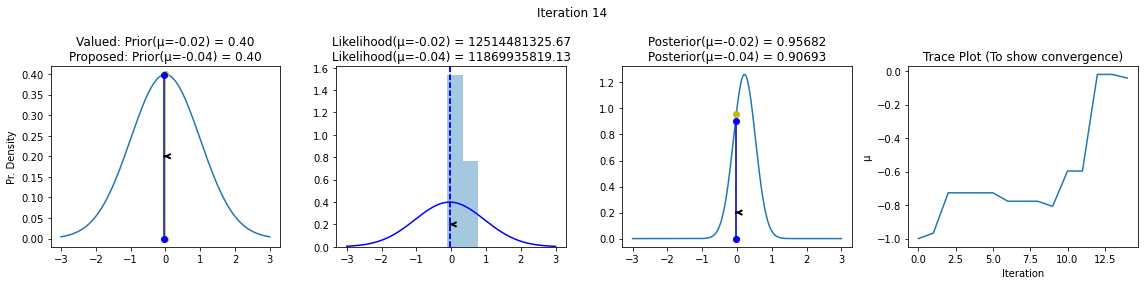

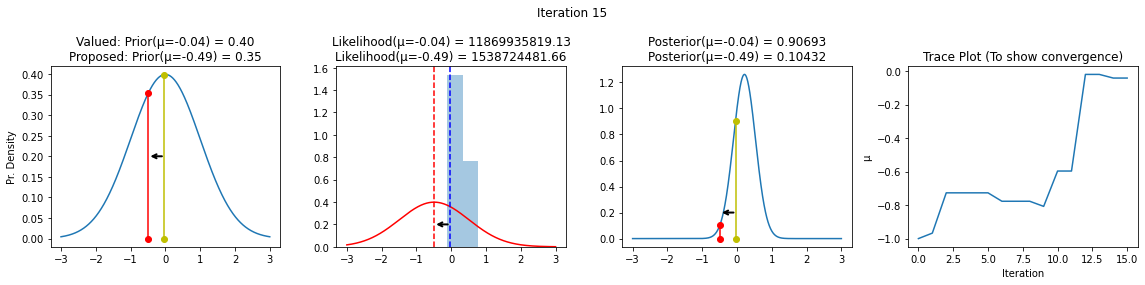

In [12]:
# Function to display
def plot_proposal(current_μ, proposed_μ, μ_prior_μ, μ_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 1000)
    color = 'b' if accepted else 'r'
        
    # To obtain plots for the prior
    prior_current = norm(μ_prior_μ, μ_prior_sd).pdf(current_μ)
    prior_proposal = norm(μ_prior_μ, μ_prior_sd).pdf(proposed_μ)
    prior = norm(μ_prior_μ, μ_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([current_μ] * 2, [0, prior_current], marker='o', color='y')
    ax1.plot([proposed_μ] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(proposed_μ, 0.2), xytext=(current_μ, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Pr. Density', title='Valued: Prior(μ=%.2f) = %.2f\nProposed: Prior(μ=%.2f) = %.2f' % (current_μ, prior_current, proposed_μ, prior_proposal))
    
    # To obtain plots for the Likelihood
    likelihood_current = norm(current_μ, 1).pdf(data).prod()
    likelihood_proposal = norm(proposed_μ, 1).pdf(data).prod()
    y = norm(loc=proposed_μ, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(current_μ, color='b', linestyle='--', label='μ_current')
    ax2.axvline(proposed_μ, color=color, linestyle='--', label='μ_proposed')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(proposed_μ, 0.2), xytext=(current_μ, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='Likelihood(μ=%.2f) = %.2f\nLikelihood(μ=%.2f) = %.2f' % (current_μ, 1e14*likelihood_current, proposed_μ, 1e14*likelihood_proposal))
    
    # To obtain plots for the Posterior
    posterior_analytical = calc_posterior_analytical(data, x, μ_prior_μ, μ_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, current_μ, μ_prior_μ, μ_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, proposed_μ, μ_prior_μ, μ_prior_sd)
    ax3.plot([current_μ] * 2, [0, posterior_current], marker='o', color='y')
    ax3.plot([proposed_μ] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(proposed_μ, 0.2), xytext=(current_μ, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='Posterior(μ=%.2f) = %.5f\nPosterior(μ=%.2f) = %.5f' % (current_μ, posterior_current, proposed_μ, posterior_proposal))
    
    if accepted:
        trace.append(proposed_μ)
    else:
        trace.append(current_μ)
    ax4.plot(trace)
    ax4.set(xlabel='Iteration', ylabel='μ', title='Trace Plot (To show convergence)') 
    plt.tight_layout()
    #plt.legend()
    
sampler(w, samples=15, μ_init=-1., plot=True);

The trace plot is a time series plot that shows the realizations of the Markov chain at each iteration against the iteration numbers. This graphical method is used to visualize how the Markov chain is moving around the state space, that is, how well it is mixing. If the MCMC chain is stuck in some part of the state space, the trace plots shows flat bits indicating slow convergence. From iteration 9, we noticed a convergence in result.

## Question 2.3

I used Cross-validation technique (K-Fold) to determine the appropriate learning rate, lambda

In [13]:
train_X, test_X, train_y, test_y = train_test_split(df.drop("lpsa", axis = 1), df["lpsa"], test_size = 0.2, random_state = 42)

learning_rates = [0, 1e-3, 1e-2, 1e-1, 1, 1e1, 10, 100, 1000, 2000, 5000]
cv = KFold(n_splits=10)

val_errors = []
for learning_rate in learning_rates:
    ridge = Ridge(alpha=learning_rate, random_state=42)
    errors = np.mean(cross_val_score(ridge, train_X, train_y, scoring='neg_mean_squared_error', cv=cv))
    val_errors.append(np.sqrt(-errors))

In [14]:
learning_rates[val_errors.index(min(val_errors))]

1

The appropriate value for $\lambda = 1$ that tends to overfit the model. We can see how the learning rate plays out across different $\lambda$.

In [15]:
def ridge(learning_rates):
    # Create an empty data frame
    data = pd.DataFrame()
    data['Feature Name'] = df.columns.drop("lpsa")
    
    # For each alpha value in the list of alpha values,
    for learning_rate in learning_rates:
        ridge = Ridge(alpha=learning_rate, random_state=42)
        ridge.fit(df.drop("lpsa", axis = 1), df["lpsa"])  
        # Create a column name for that alpha value
        column_name = 'lr = %f' % learning_rate
        # Create a column of coefficient values
        data[column_name] = ridge.coef_
  
    # Return the dataframe   
    return data

ridge(learning_rates)

,Feature Name,lr = 0.000000,lr = 0.001000,lr = 0.010000,lr = 0.100000,lr = 1.000000,lr = 10.000000,lr = 100.000000,lr = 1000.000000,lr = 2000.000000,lr = 5000.000000
0,lcavol,0.564341,0.564341,0.564342,0.564345,0.563762,0.532865,0.301768,0.062290,0.033454,0.014157
1,lweight,0.622020,0.621979,0.621608,0.617932,0.583576,0.382318,0.106300,0.016211,0.008500,0.003540
2,age,-0.021248,-0.021247,-0.021239,-0.021155,-0.020372,-0.015395,-0.003120,0.005588,0.005732,0.004703
3,lbph,0.096713,0.096714,0.096727,0.096858,0.098121,0.104986,0.079876,0.018223,0.009925,0.004294
4,svi,0.761673,0.761588,0.760821,0.753239,0.685508,0.373626,0.091962,0.015356,0.008156,0.003440
5,lcp,-0.106051,-0.106031,-0.105851,-0.104073,-0.087804,0.001383,0.106710,0.036151,0.020200,0.008876
6,gleason,0.049228,0.049217,0.049115,0.048109,0.039376,0.009284,0.009695,0.003444,0.002048,0.001052
7,pgg45,0.004458,0.004458,0.004459,0.004473,0.004591,0.004970,0.007392,0.014162,0.015085,0.015337


## QUESTION 2.4

1. Finding the `eigenvalue`, `eigenvector` and `covariance` to solve the principal componenets

In [17]:
df_centered = df - df.mean() #mean centering
cov = np.cov(df_centered.iloc[:, :-1], rowvar = False)
evals , evecs = np.linalg.eig(cov)

# sort results wrt. eigenvalues
idx = evals.argsort()[::-1]
evals, evecs = evals[idx], evecs[:, idx]

# projections of X on the principal axes are called principal components
principal_components = df_centered.iloc[:, :-1].dot(evecs)

In [ ]:
principal_components.columns = ["z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8"]
from sklearn.decomposition import PCA
pca = PCA(n_components = 8)
X2D = pca.fit_transform(df.iloc[:, :-1]) 
pd.DataFrame(X2D, columns = ["z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8"])
principal_components

,z1,z2,z3,z4,z5,z6,z7,z8
0,-25.459202,12.030635,-0.538722,-1.335912,-0.574250,-0.012538,0.368914,0.122934
1,-24.845056,4.074839,-0.383910,-1.917513,-1.002525,0.089402,-0.122153,0.049582
2,-3.654424,-10.273257,0.109555,-3.146353,-0.743257,-0.604385,0.513588,0.156981
3,-24.848936,4.079094,-0.484650,-2.022187,-1.154771,0.061686,-0.114518,0.063587
4,-24.502729,0.067452,0.645971,-1.303411,0.170393,0.276855,0.039887,-0.044356
...,...,...,...,...,...,...,...,...
92,35.878536,-1.243826,1.853127,-0.595723,0.235356,0.627420,-0.179679,0.275541
93,14.138598,21.048719,2.189831,2.165541,0.704699,0.286596,-0.361884,0.176673
94,-15.132307,10.792222,3.091581,2.077010,-0.585431,-0.461103,-0.001748,0.305018
95,55.821790,0.105133,-0.581274,1.122968,0.226914,0.871527,0.312716,0.334446


2. Using **Singular Value Decomposition (SVD)** technique to decompose the training set matrix `df_standardize` into the matrix multiplication of three matrices `U` `Σ`, `V`<sup>T</sup>, where `V` contains the unit vectors that define all the principal components that we are looking for.

In [ ]:
df_centered = df - df.mean() #mean centering
U, sigma, Vt = np.linalg.svd(df_centered.iloc[:, :-1]) #response variable not included
W2 = Vt.T[:, :]

In [ ]:
#print out the principal components
pc = df_centered.iloc[:, :-1].dot(W2)
pc.columns = ["z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8"]
pc

,z1,z2,z3,z4,z5,z6,z7,z8
0,-25.459202,12.030635,-0.538722,1.335912,-0.574250,-0.012538,-0.368914,0.122934
1,-24.845056,4.074839,-0.383910,1.917513,-1.002525,0.089402,0.122153,0.049582
2,-3.654424,-10.273257,0.109555,3.146353,-0.743257,-0.604385,-0.513588,0.156981
3,-24.848936,4.079094,-0.484650,2.022187,-1.154771,0.061686,0.114518,0.063587
4,-24.502729,0.067452,0.645971,1.303411,0.170393,0.276855,-0.039887,-0.044356
...,...,...,...,...,...,...,...,...
92,35.878536,-1.243826,1.853127,0.595723,0.235356,0.627420,0.179679,0.275541
93,14.138598,21.048719,2.189831,-2.165541,0.704699,0.286596,0.361884,0.176673
94,-15.132307,10.792222,3.091581,-2.077010,-0.585431,-0.461103,0.001748,0.305018
95,55.821790,0.105133,-0.581274,-1.122968,0.226914,0.871527,-0.312716,0.334446


Both methods obtained same Principal Components (PCs)

(-1.6054775107500001, 4.0794074697500005, 2.2546321500000004, 4.90065685)

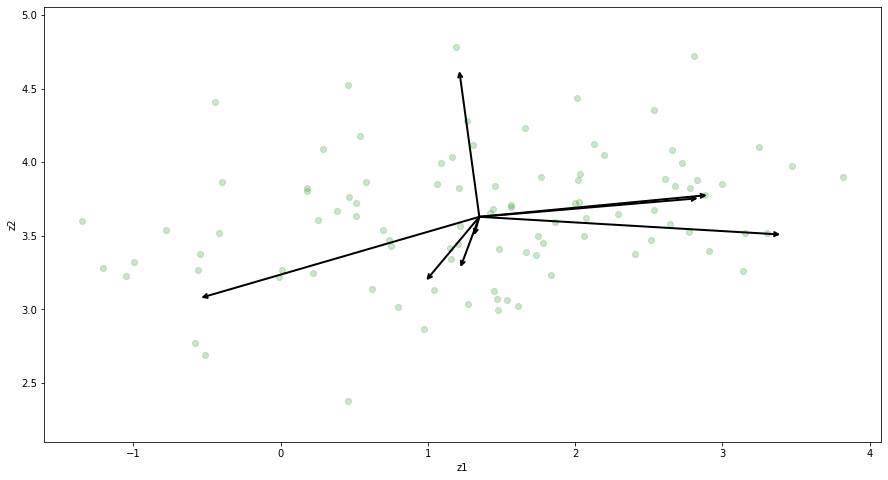

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.figure(figsize=(15, 8))
df = df.values
plt.scatter(df[:, 0], df[:, 1], alpha=0.2, color="green")
plt.xlabel("z1"), plt.ylabel('z2')
for len, vec in zip(pca.explained_variance_, pca.components_[:, :2]):
    v = vec * 3 * np.sqrt(len)
    draw_vector(pca.mean_[:2], pca.mean_[:2] + v)
plt.axis('equal')

From the plot, 2 PCs seems to carry much information and it's save to reduce the dimensionality of the training predictor into 2 PCs, and this can be verified below:

In [ ]:
pca.explained_variance_ratio_[:8]

array([9.34850309e-01, 5.97407213e-02, 2.29917376e-03, 2.05144759e-03,
       5.57711461e-04, 2.61499680e-04, 1.41613378e-04, 9.75236216e-05])